# Elliptic (Laplace-smoothed) (s, r, delta) parameterization

This notebook focuses on a single strategy: generate a smooth elliptic grid between
an initial and final fire boundary, then examine how well it covers the between-boundaries
mask. We test multiple fire shapes (smooth vs jagged/deformed) and visualize:
- grid coverage + sample density
- s, r, and delta fields across the mask
- mapping distances from grid to the domain

In [233]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import replace
from scipy.ndimage import gaussian_filter, distance_transform_edt
from scipy.spatial import cKDTree

from fire_model.ca import FireEnv, FireState, CAFireModel
from fire_model.boundary import extract_fire_boundary

np.set_printoptions(precision=3, suppress=True)
plt.rcParams["figure.dpi"] = 120

rng = np.random.default_rng(7)

In [234]:
# Helper utilities.

def firestate_from_prob(p_map, t=0, burn_remaining_s=None):
    p = np.clip(p_map, 0.0, 1.0)
    zeros = np.zeros_like(p)
    if burn_remaining_s is None:
        burn_map = zeros
    else:
        burn_map = np.full_like(p, float(burn_remaining_s))
    return FireState(
        burning=p[None, :, :],
        burned=zeros[None, :, :],
        burn_remaining_s=burn_map[None, :, :],
        retardant=zeros[None, :, :],
        t=int(t),
    )


def boundary_tangent_angles(xy):
    d = np.roll(xy, -1, axis=0) - np.roll(xy, 1, axis=0)
    return np.arctan2(d[:, 1], d[:, 0])


def wrap_angle(theta):
    return (theta + np.pi) % (2.0 * np.pi) - np.pi


def build_linear_grid(boundary0_xy, boundary1_xy, r_targets):
    r_targets = np.asarray(r_targets, dtype=float)
    grid = np.zeros((boundary0_xy.shape[0], r_targets.size, 2), dtype=float)
    for j, r in enumerate(r_targets):
        grid[:, j, :] = (1.0 - r) * boundary0_xy + r * boundary1_xy
    return grid


def smooth_grid_laplace(grid, *, n_iters=300, omega=1.0):
    g = grid.copy()
    for _ in range(int(n_iters)):
        avg = 0.25 * (
            np.roll(g, 1, axis=0)
            + np.roll(g, -1, axis=0)
            + np.roll(g, 1, axis=1)
            + np.roll(g, -1, axis=1)
        )
        g[:, 1:-1, :] = (1.0 - omega) * g[:, 1:-1, :] + omega * avg[:, 1:-1, :]
    return g


def coverage_stats(grid, mask):
    pts = grid.reshape(-1, 2)
    pts = pts[np.isfinite(pts[:, 0]) & np.isfinite(pts[:, 1])]
    if pts.size == 0:
        return 0.0, np.zeros_like(mask, dtype=int)
    nx, ny = mask.shape
    ix = np.clip(np.round(pts[:, 0]).astype(int), 0, nx - 1)
    iy = np.clip(np.round(pts[:, 1]).astype(int), 0, ny - 1)
    counts = np.zeros((nx, ny), dtype=int)
    np.add.at(counts, (ix, iy), 1)
    covered = (counts > 0) & mask
    coverage = float(covered.sum()) / max(mask.sum(), 1)
    return coverage, counts


def grid_outside_fraction(grid, mask):
    pts = grid.reshape(-1, 2)
    valid = np.isfinite(pts[:, 0]) & np.isfinite(pts[:, 1])
    pts = pts[valid]
    if pts.size == 0:
        return np.nan
    nx, ny = mask.shape
    ix = np.clip(np.round(pts[:, 0]).astype(int), 0, nx - 1)
    iy = np.clip(np.round(pts[:, 1]).astype(int), 0, ny - 1)
    inside = mask[ix, iy]
    return 1.0 - float(np.mean(inside))


def jacobian_from_grid(grid, s_vals, r_vals):
    ds = float(s_vals[1] - s_vals[0]) if len(s_vals) > 1 else 1.0
    dr = float(r_vals[1] - r_vals[0]) if len(r_vals) > 1 else 1.0
    dx_ds = np.gradient(grid[:, :, 0], axis=0) / ds
    dy_ds = np.gradient(grid[:, :, 1], axis=0) / ds
    dx_dr = np.gradient(grid[:, :, 0], axis=1) / dr
    dy_dr = np.gradient(grid[:, :, 1], axis=1) / dr
    return dx_ds * dy_dr - dy_ds * dx_dr


def evaluate_grid(grid, mask, r_targets):
    coverage, _ = coverage_stats(grid, mask)
    s_vals = np.linspace(0.0, 1.0, grid.shape[0], endpoint=False)
    jac = jacobian_from_grid(grid, s_vals, r_targets)
    finite = np.isfinite(jac)
    min_jac = float(np.min(jac[finite])) if np.any(finite) else np.nan
    frac_negative = float(np.mean(jac[finite] < 0.0)) if np.any(finite) else np.nan
    outside = grid_outside_fraction(grid, mask)
    valid_frac = float(np.mean(np.isfinite(grid[..., 0]) & np.isfinite(grid[..., 1])))
    return {
        "coverage": coverage,
        "min_jac": min_jac,
        "neg_jac_frac": frac_negative,
        "outside_frac": outside,
        "valid_frac": valid_frac,
    }


def grid_angle_along_s(grid):
    d = np.roll(grid, -1, axis=0) - np.roll(grid, 1, axis=0)
    return np.arctan2(d[:, :, 1], d[:, :, 0])


def grid_to_fields(grid, r_targets, boundary0_xy, mask):
    pts = grid.reshape(-1, 2)
    valid = np.isfinite(pts[:, 0]) & np.isfinite(pts[:, 1])
    pts_valid = pts[valid]
    valid_flat = np.flatnonzero(valid)

    coords = np.column_stack(np.where(mask))
    tree = cKDTree(pts_valid)
    dist, idx = tree.query(coords, k=1)

    flat_idx = valid_flat[idx]
    s_idx = flat_idx // grid.shape[1]
    r_idx = flat_idx % grid.shape[1]

    s_vals = s_idx / grid.shape[0]
    r_vals = r_targets[r_idx]

    s_field = np.full(mask.shape, np.nan)
    r_field = np.full(mask.shape, np.nan)
    dist_field = np.full(mask.shape, np.nan)

    s_field[coords[:, 0], coords[:, 1]] = s_vals
    r_field[coords[:, 0], coords[:, 1]] = r_vals
    dist_field[coords[:, 0], coords[:, 1]] = dist

    tangent = boundary_tangent_angles(boundary0_xy)
    phi_grid = grid_angle_along_s(grid)
    delta_grid = wrap_angle(phi_grid - tangent[:, None])
    delta_field = np.full(mask.shape, np.nan)
    delta_vals = delta_grid[s_idx, r_idx]
    delta_field[coords[:, 0], coords[:, 1]] = delta_vals

    return s_field, r_field, delta_field, dist_field


def plot_grid_lines(ax, grid, mask, title, step_s=16, step_r=8):
    ax.imshow(mask.T, origin="lower", aspect="equal", cmap="Greys", alpha=0.35)
    for j in range(0, grid.shape[1], step_r):
        curve = grid[:, j]
        ax.plot(curve[:, 0], curve[:, 1], color="tab:blue", linewidth=1)
    for i in range(0, grid.shape[0], step_s):
        curve = grid[i]
        ax.plot(curve[:, 0], curve[:, 1], color="tab:orange", linewidth=0.7, alpha=0.7)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])


def make_prob_map(nx, ny, center, radius_cells, *, stretch=(1.0, 1.0), jitter_amp=0.0, k1=0, k2=0, phase=0.0, sigma=2.0):
    xs = np.arange(nx)[:, None]
    ys = np.arange(ny)[None, :]
    cx, cy = center
    dx = (xs - cx) / float(stretch[0])
    dy = (ys - cy) / float(stretch[1])
    theta = np.arctan2(dy, dx)
    r = np.hypot(dx, dy)

    r0 = float(radius_cells)
    if jitter_amp > 0.0:
        r0 = r0 * (1.0 + jitter_amp * np.sin(k1 * theta + phase) + 0.15 * np.sin(k2 * theta + 0.4))

    p = 1.0 / (1.0 + np.exp((r - r0) / float(sigma)))
    return np.clip(p, 0.0, 1.0)

In [235]:
# Environment + model.

nx = ny = 150
domain_km = 2.0
fuel = np.ones((nx, ny), dtype=float)
value = np.ones((nx, ny), dtype=float)
wind = np.zeros((nx, ny, 2), dtype=float)
wind[..., 0] = 6.0
wind[..., 1] = 1.5

env = FireEnv(
    grid_size=(nx, ny),
    domain_km=domain_km,
    fuel=fuel,
    value=value,
    wind=wind,
    dt_s=3.0,
    burn_time_s0=600.0,
    retardant_half_life_s=3600.0,
    retardant_k=10.0,
    drop_w_km=0.05,
    drop_h_km=0.40,
    drop_amount=1.0,
    ros_mps=1.0,
    wind_coeff=0.08,
    diag=True,
    avoid_burning_drop=True,
    avoid_drop_p_threshold=0.25,
    ros_future_jitter_frac=0.10,
    wind_coeff_future_jitter_frac=0.10,
)

model = CAFireModel(env, seed=4)

In [236]:
# Elliptic grid experiment runner.

def run_elliptic_case(name, p_init, *, T=300.0, n_sims=200, K=500, n_r=140, sigma_boundary=2.0, smooth_iters=300, omega=1.0, model_override=None):
    model_local = model if model_override is None else model_override
    init_state = firestate_from_prob(p_init, burn_remaining_s=model_local.env.burn_time_s0)
    final_state = model_local.simulate_from_firestate(
        init_state,
        T=T,
        n_sims=n_sims,
        ros_mps=1.0,
        wind_coeff=0.08,
        diag=True,
    )

    p_init_smooth = gaussian_filter(p_init, sigma=sigma_boundary)
    p_final = np.clip(final_state.burning[0] + final_state.burned[0], 0.0, 1.0)
    p_final_smooth = gaussian_filter(p_final, sigma=sigma_boundary)

    init_state_macro = firestate_from_prob(p_init_smooth, t=0, burn_remaining_s=model_local.env.burn_time_s0)
    final_state_macro = firestate_from_prob(p_final_smooth, t=int(final_state.t), burn_remaining_s=model_local.env.burn_time_s0)

    init_boundary = extract_fire_boundary(
        init_state_macro,
        K=K,
        p_boundary=0.25,
        field="affected",
        anchor="max_x",
        ccw=True,
    )
    final_boundary = extract_fire_boundary(
        final_state_macro,
        K=K,
        p_boundary=0.5,
        field="affected",
        anchor="max_x",
        ccw=True,
    )

    mask = model_local.discretise_between_boundaries(init_boundary, final_boundary)

    r_targets = np.linspace(0.0, 1.0, int(n_r))
    grid_linear = build_linear_grid(init_boundary.xy, final_boundary.xy, r_targets)
    grid_elliptic = smooth_grid_laplace(grid_linear, n_iters=smooth_iters, omega=omega)

    stats = evaluate_grid(grid_elliptic, mask, r_targets)
    coverage, counts = coverage_stats(grid_elliptic, mask)

    s_field, r_field, delta_field, dist_field = grid_to_fields(
        grid_elliptic,
        r_targets,
        init_boundary.xy,
        mask,
    )

    print(f"=== {name} ===")
    print(
        f"coverage={stats['coverage']:.3f}  outside={stats['outside_frac']:.3f}  "
        f"min_jac={stats['min_jac']:.3f}  neg_jac={stats['neg_jac_frac']:.3f}  valid={stats['valid_frac']:.3f}"
    )

    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes[0, 0].imshow(p_init.T, origin="lower", vmin=0.0, vmax=1.0, aspect="equal")
    axes[0, 0].plot(init_boundary.xy[:, 0], init_boundary.xy[:, 1], color="tab:red", linewidth=2)
    axes[0, 0].set_title(f"{name}: init p + boundary")
    axes[0, 0].set_xticks([])
    axes[0, 0].set_yticks([])

    axes[0, 1].imshow(p_final.T, origin="lower", vmin=0.0, vmax=1.0, aspect="equal")
    axes[0, 1].plot(final_boundary.xy[:, 0], final_boundary.xy[:, 1], color="tab:green", linewidth=2)
    axes[0, 1].set_title(f"{name}: final p + boundary")
    axes[0, 1].set_xticks([])
    axes[0, 1].set_yticks([])

    plot_grid_lines(axes[0, 2], grid_elliptic, mask, f"{name}: elliptic grid")

    axes[1, 0].imshow(counts.T, origin="lower", aspect="equal", cmap="magma")
    axes[1, 0].set_title("sample density")
    axes[1, 0].set_xticks([])
    axes[1, 0].set_yticks([])

    axes[1, 1].imshow(s_field.T, origin="lower", aspect="equal", cmap="viridis")
    axes[1, 1].set_title("s field")
    axes[1, 1].set_xticks([])
    axes[1, 1].set_yticks([])

    axes[1, 2].imshow(r_field.T, origin="lower", aspect="equal", cmap="viridis")
    axes[1, 2].set_title("r field")
    axes[1, 2].set_xticks([])
    axes[1, 2].set_yticks([])

    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(1, 3, figsize=(12, 3.8))
    im0 = axes[0].imshow(np.degrees(delta_field).T, origin="lower", aspect="equal", cmap="twilight", vmin=-180, vmax=180)
    axes[0].set_title("delta field (deg)")
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    plt.colorbar(im0, ax=axes[0], fraction=0.046)

    im1 = axes[1].imshow(dist_field.T, origin="lower", aspect="equal", cmap="viridis")
    axes[1].set_title("distance to nearest grid point")
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    plt.colorbar(im1, ax=axes[1], fraction=0.046)

    axes[2].hist(dist_field[np.isfinite(dist_field)].ravel(), bins=30, color="tab:blue", alpha=0.8)
    axes[2].set_title("distance histogram")
    axes[2].set_xlabel("distance (cells)")

    plt.tight_layout()
    plt.show()

    return {
        "grid": grid_elliptic,
        "mask": mask,
        "r_targets": r_targets,
        "stats": stats,
        "init_boundary": init_boundary,
        "final_boundary": final_boundary,
        "p_init": p_init,
        "p_final": p_final,
    }


In [237]:
# Scenarios: smooth vs jagged/deformed.

center = (nx // 2, ny // 2)

scenarios = [
    {
        "name": "smooth",
        "p_init": make_prob_map(nx, ny, center, radius_cells=14, stretch=(1.0, 1.0), jitter_amp=0.0, sigma=2.5),
    },
    {
        "name": "jagged",
        "p_init": make_prob_map(
            nx,
            ny,
            center,
            radius_cells=14,
            stretch=(1.0, 1.35),
            jitter_amp=0.28,
            k1=5,
            k2=11,
            phase=0.6,
            sigma=2.0,
        ),
    },
    {
        "name": "jagged_lobed",
        "p_init": make_prob_map(
            nx,
            ny,
            center,
            radius_cells=13,
            stretch=(0.9, 1.4),
            jitter_amp=0.35,
            k1=7,
            k2=13,
            phase=1.2,
            sigma=1.8,
        ),
    },
]

No drone_params
=== smooth ===
coverage=1.000  outside=0.007  min_jac=-24334.816  neg_jac=1.000  valid=1.000


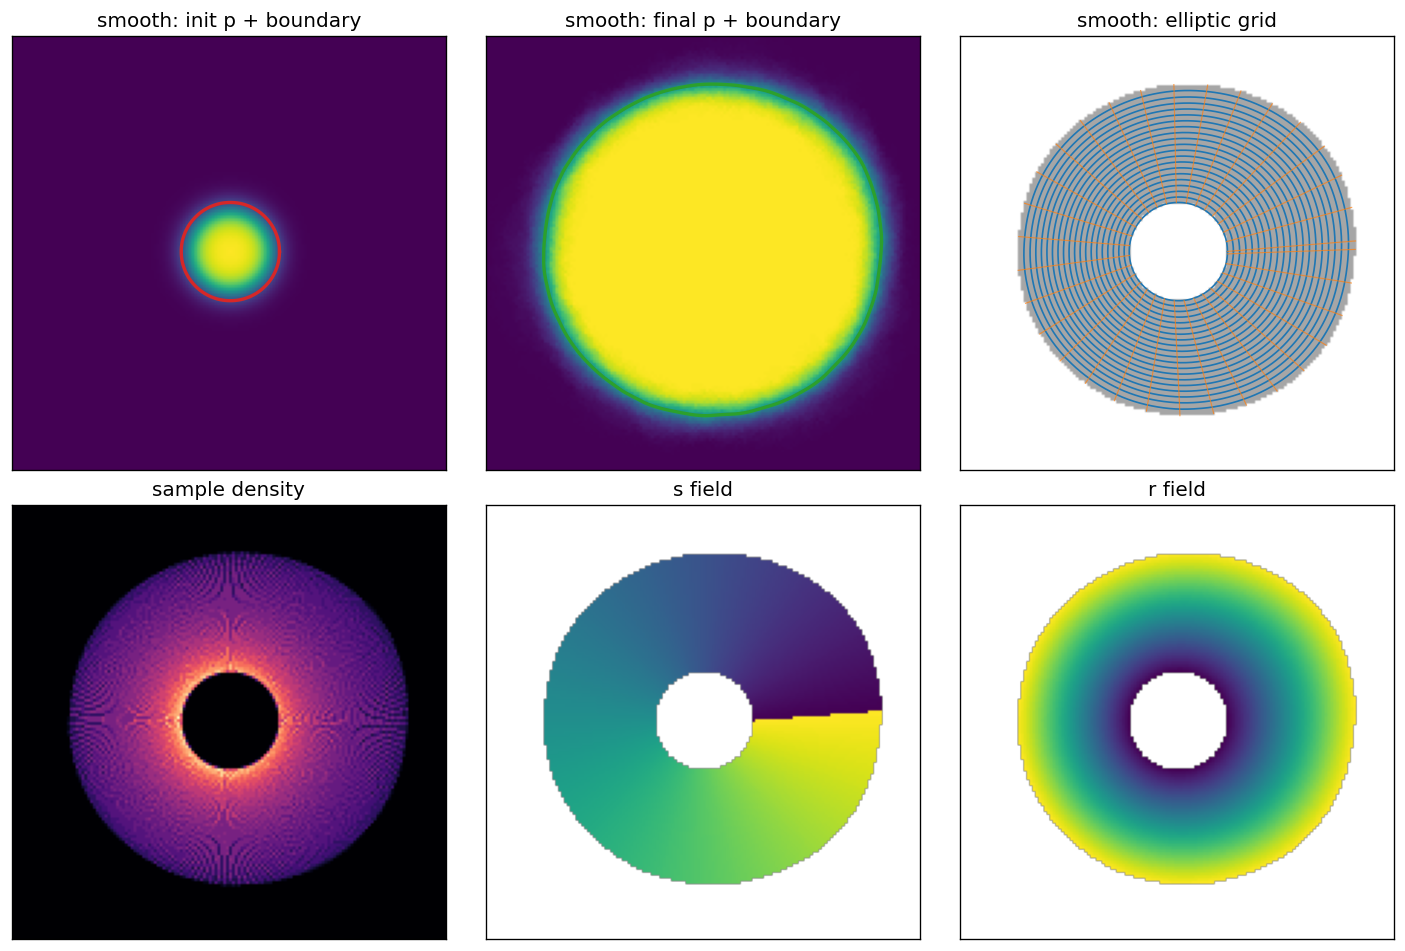

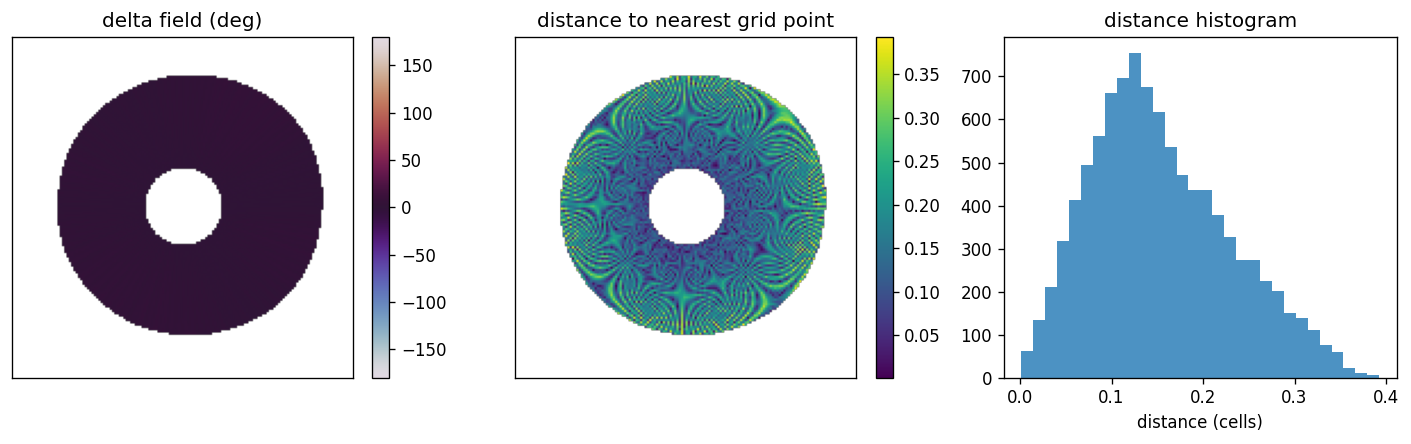

No drone_params
=== jagged ===
coverage=1.000  outside=0.013  min_jac=-30767.387  neg_jac=0.999  valid=1.000


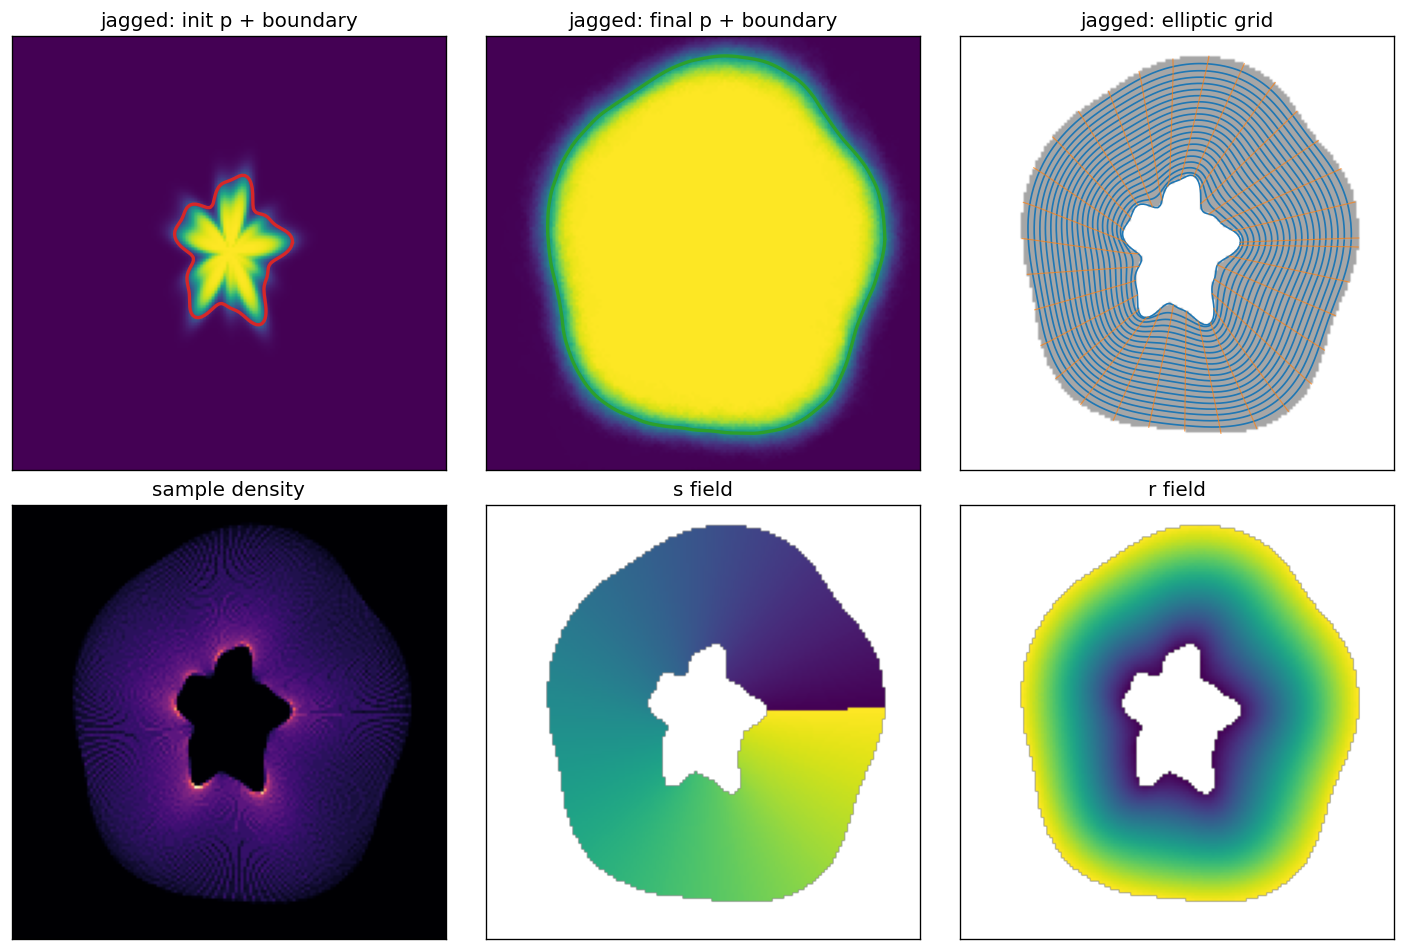

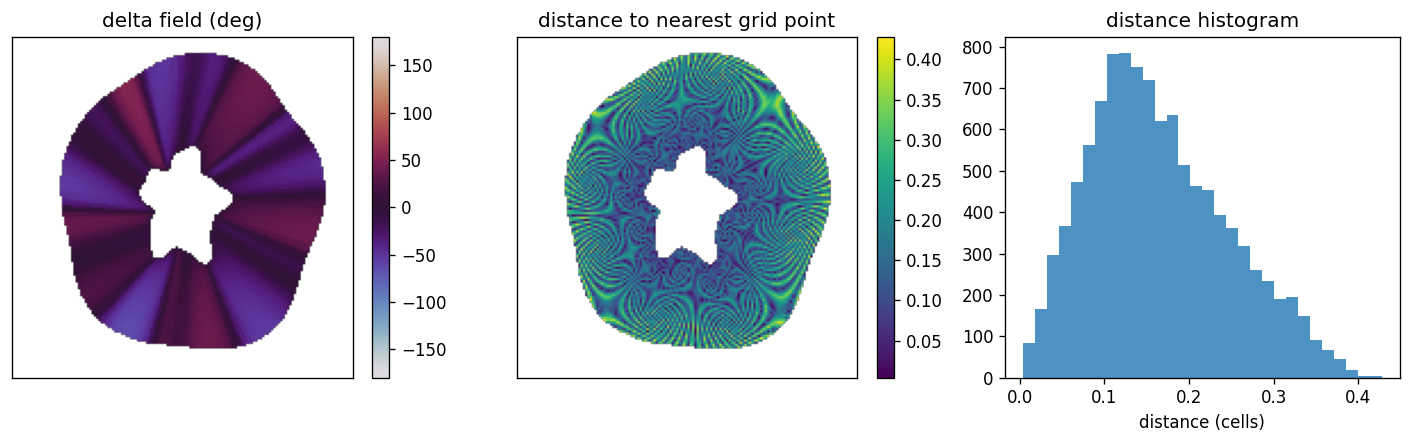

No drone_params
=== jagged_lobed ===
coverage=1.000  outside=0.014  min_jac=-28783.175  neg_jac=0.998  valid=1.000


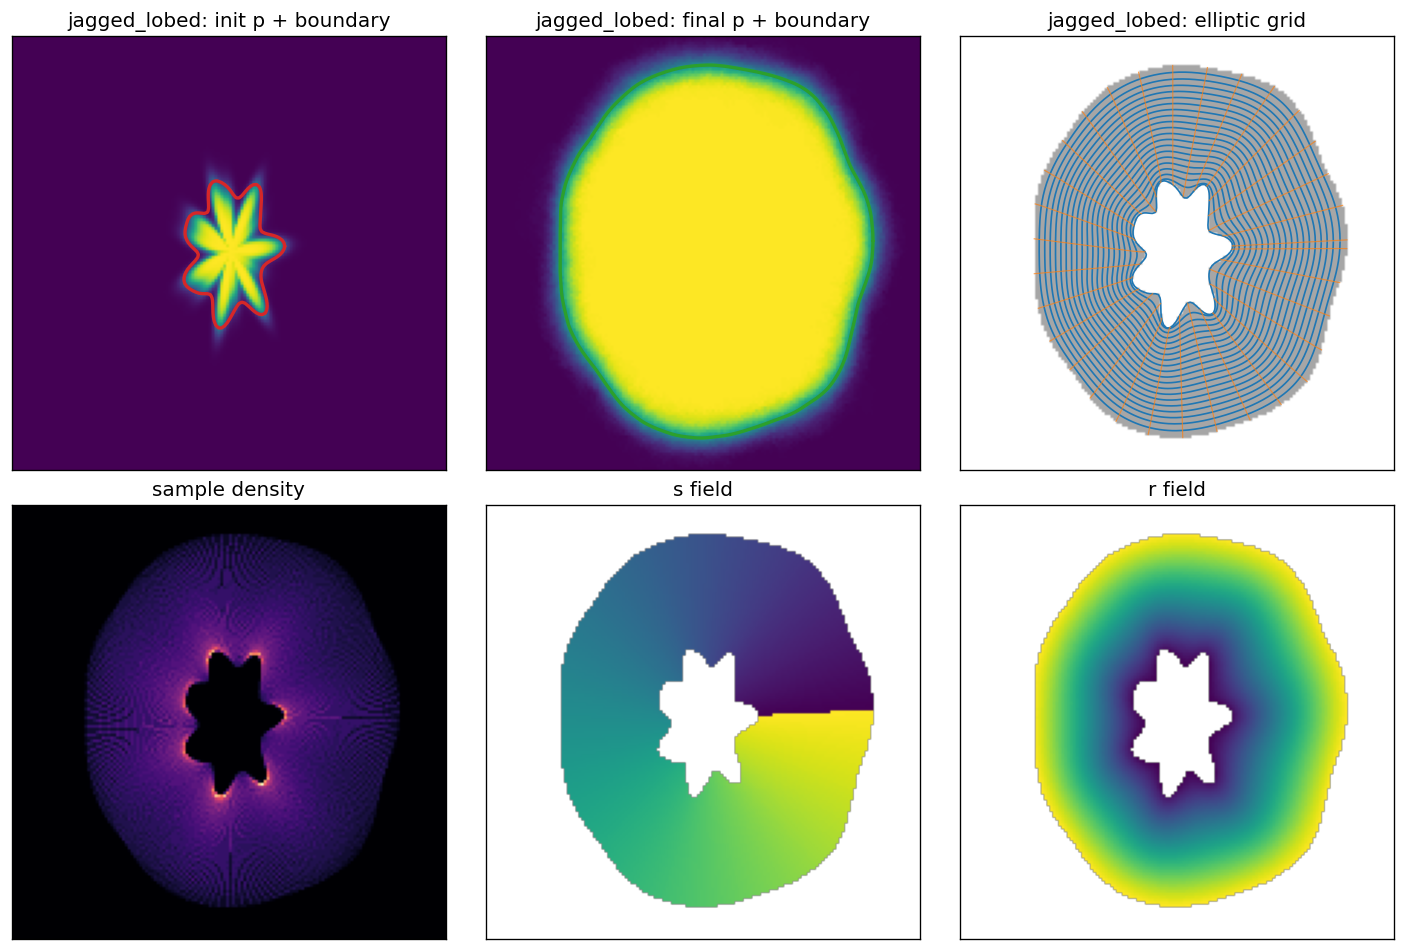

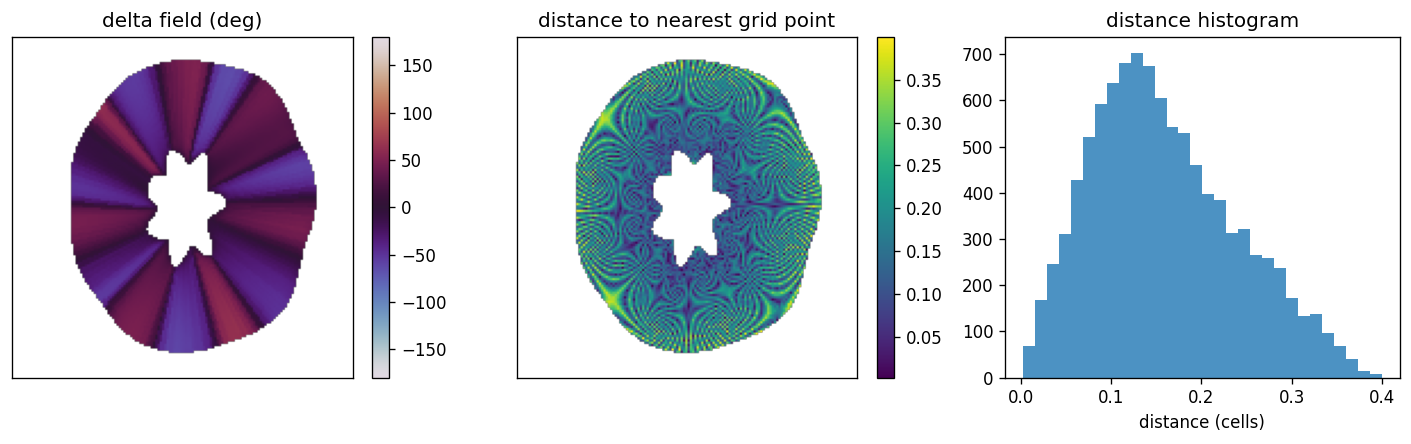

In [238]:
# Run all scenarios with elliptic smoothing.

results = []
for sc in scenarios:
    res = run_elliptic_case(
        sc["name"],
        sc["p_init"],
        T=150.0,
        n_sims=200,
        K=500,
        n_r=160,
        sigma_boundary=2.0,
        smooth_iters=350,
        omega=1.0,
    )
    results.append(res)

Applying retardant drop: D=[[ 92.445  98.472   0.564]
 [ 39.789  71.618  -3.016]
 [103.46   25.179  -1.001]], amount=1.0, drop_w_km=0.05, drop_h_km=0.5
Drop (s, r) targets: [(0.12, 0.25), (0.5, 0.55), (0.82, 0.8)]
Drop indices (s_idx, r_idx): [(60, 40), (250, 87), (409, 127)]
Drop params (x, y, phi): [[ 92.445  98.472   0.564]
 [ 39.789  71.618  -3.016]
 [103.46   25.179  -1.001]]


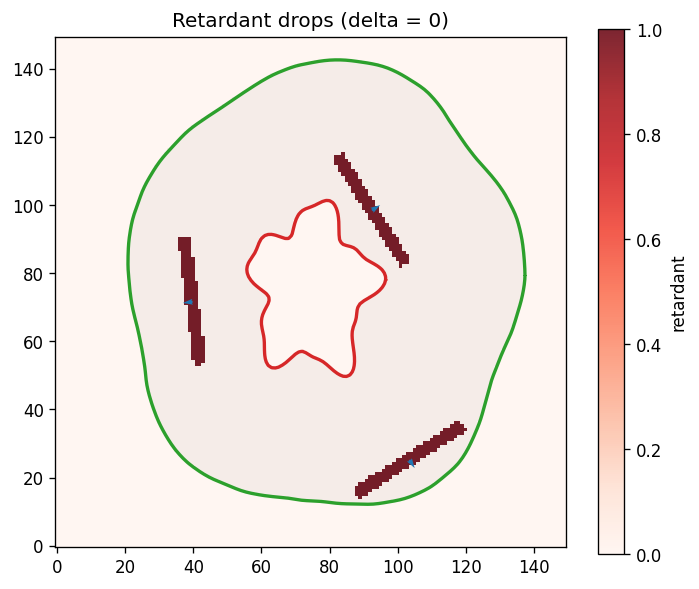

In [239]:
# Retardant drops at specific (s, r) with delta = 0.
# delta = 0 => long axis aligns with s-direction, perpendicular to r-lines.

scenario_idx = 1  # 0=smooth, 1=jagged, 2=jagged_lobed
res = results[scenario_idx]

grid = res["grid"]
r_targets = res["r_targets"]
mask = res["mask"]
init_boundary = res["init_boundary"]
final_boundary = res["final_boundary"]

# choose three (s, r) locations
sr_targets = [(0.12, 0.25), (0.50, 0.55), (0.82, 0.80)]

s_idx = [int(round(s * (grid.shape[0] - 1))) for s, _ in sr_targets]
r_idx = [int(round(r * (grid.shape[1] - 1))) for _, r in sr_targets]

points = np.array([grid[i, j] for i, j in zip(s_idx, r_idx)], dtype=float)
phi_grid = grid_angle_along_s(grid)
phi = np.array([phi_grid[i, j] for i, j in zip(s_idx, r_idx)], dtype=float) - np.pi / 2.0

# Build a blank state and apply drops (5m x 50m).
state = FireState(
    burning=np.zeros((1, nx, ny), dtype=bool),
    burned=np.zeros((1, nx, ny), dtype=bool),
    burn_remaining_s=np.zeros((1, nx, ny), dtype=float),
    retardant=np.zeros((1, nx, ny), dtype=float),
    t=0,
)

drone_params = np.column_stack([points[:, 0], points[:, 1], phi])

model.apply_retardant_cartesian(
    state,
    drone_params,
    drop_w_km=0.05,
    drop_h_km=0.5,
    amount=1.0,
    avoid_burning=False,
    forbid_burning_overlap=False,
    burning_prob_threshold=0.25,
    cell_cap=None,
)

print("Drop (s, r) targets:", sr_targets)
print("Drop indices (s_idx, r_idx):", list(zip(s_idx, r_idx)))
print("Drop params (x, y, phi):", drone_params)

plt.figure(figsize=(6, 5))
plt.imshow(mask.T, origin="lower", aspect="equal", cmap="Greys", alpha=0.25)
ret = state.retardant[0]
im = plt.imshow(ret.T, origin="lower", aspect="equal", cmap="Reds", alpha=0.85)
plt.colorbar(im, label="retardant")
plt.plot(init_boundary.xy[:, 0], init_boundary.xy[:, 1], color="tab:red", linewidth=2)
plt.plot(final_boundary.xy[:, 0], final_boundary.xy[:, 1], color="tab:green", linewidth=2)
plt.quiver(
    points[:, 0],
    points[:, 1],
    np.cos(phi),
    np.sin(phi),
    angles="xy",
    scale_units="xy",
    scale=0.35,
    color="tab:blue",
    width=0.004,
)
plt.title("Retardant drops (delta = 0)")
plt.tight_layout()
plt.show()


Applying retardant drop: D=[[ 58.694  63.482  -1.512]
 [ 70.047  37.391  -0.164]
 [ 68.786  94.206  -2.125]
 [ 43.467  69.063  -1.463]
 [111.56   48.48    1.224]
 [ 97.908  58.232   1.279]
 [105.849 112.798   2.201]
 [ 86.381 123.693   2.935]
 [ 96.466  78.211   1.528]
 [137.388  79.695   1.573]
 [ 96.437  77.896   1.381]
 [137.379  78.912   1.54 ]
 [115.085  83.991   1.803]
 [114.691  73.457   1.286]
 [ 60.922  71.573  -1.662]
 [ 22.738  71.741  -1.417]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2
Applying retardant drop: D=[[ 58.694  63.482   0.059]
 [ 70.047  37.391   1.407]
 [ 68.786  94.206  -0.554]
 [ 43.467  69.063   0.107]
 [111.56   48.48    2.795]
 [ 97.908  58.232   2.849]
 [105.849 112.798   3.772]
 [ 86.381 123.693   4.506]
 [ 96.466  78.211   3.098]
 [137.388  79.695   3.144]
 [ 96.437  77.896   2.952]
 [137.379  78.912   3.111]
 [115.085  83.991   3.373]
 [114.691  73.457   2.857]
 [ 60.922  71.573  -0.091]
 [ 22.738  71.741   0.154]], amount=1.0, drop_w_km=0.05, drop_h_k

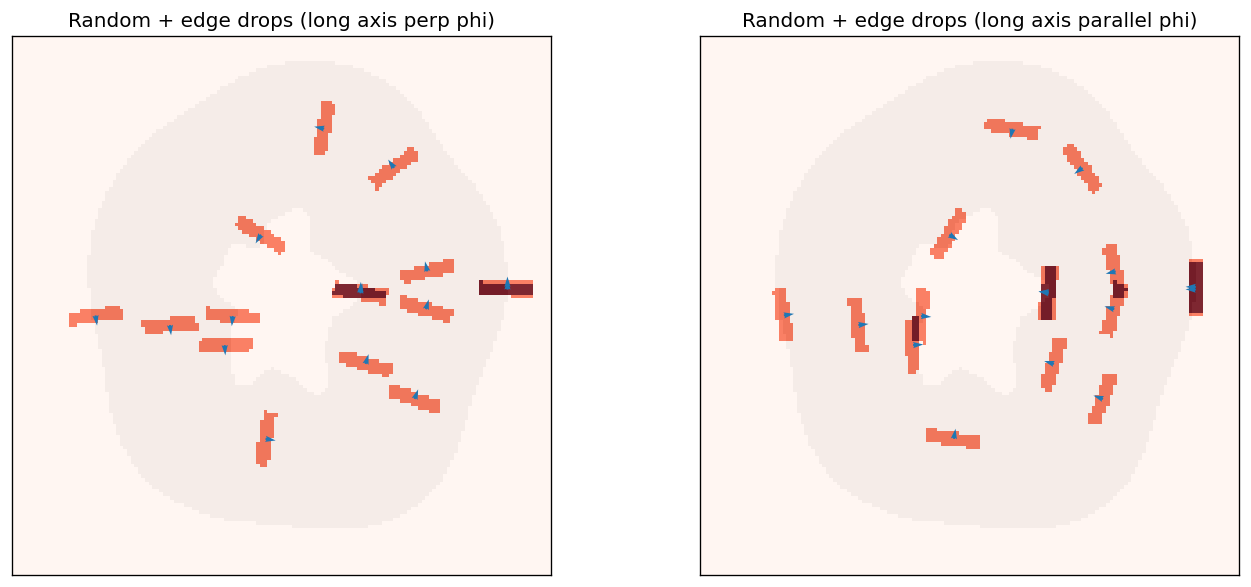

In [240]:
# Additional drop tests: random (s, r) and boundary/edge cases.

np.random.seed(3)

# Random sr samples
n_random = 8
rand_s = np.random.uniform(0.0, 1.0, size=n_random)
rand_r = np.random.uniform(0.0, 1.0, size=n_random)
rand_sr = list(zip(rand_s, rand_r))

# Boundary / edge sr samples
edge_sr = [
    (0.0, 0.0),
    (0.0, 1.0),
    (1.0, 0.0),
    (1.0, 1.0),
    (0.02, 0.5),
    (0.98, 0.5),
    (0.5, 0.02),
    (0.5, 0.98),
]

all_sr = rand_sr + edge_sr

s_idx = [int(round(s * (grid.shape[0] - 1))) for s, _ in all_sr]
r_idx = [int(round(r * (grid.shape[1] - 1))) for _, r in all_sr]

points = np.array([grid[i, j] for i, j in zip(s_idx, r_idx)], dtype=float)
phi_grid = grid_angle_along_s(grid)

# Case 1: long axis perpendicular to phi (default in apply_retardant_cartesian)
phi_perp = np.array([phi_grid[i, j] for i, j in zip(s_idx, r_idx)], dtype=float)

# Case 2: long axis parallel to phi (rotate by +90 deg)
phi_parallel = phi_perp + np.pi / 2.0

state_perp = FireState(
    burning=np.zeros((1, nx, ny), dtype=bool),
    burned=np.zeros((1, nx, ny), dtype=bool),
    burn_remaining_s=np.zeros((1, nx, ny), dtype=float),
    retardant=np.zeros((1, nx, ny), dtype=float),
    t=0,
)

state_parallel = FireState(
    burning=np.zeros((1, nx, ny), dtype=bool),
    burned=np.zeros((1, nx, ny), dtype=bool),
    burn_remaining_s=np.zeros((1, nx, ny), dtype=float),
    retardant=np.zeros((1, nx, ny), dtype=float),
    t=0,
)

model.apply_retardant_cartesian(
    state_perp,
    np.column_stack([points[:, 0], points[:, 1], phi_perp]),
    drop_w_km=0.05,
    drop_h_km=0.2,
    amount=1.0,
    avoid_burning=False,
    forbid_burning_overlap=False,
    burning_prob_threshold=0.25,
    cell_cap=None,
)

model.apply_retardant_cartesian(
    state_parallel,
    np.column_stack([points[:, 0], points[:, 1], phi_parallel]),
    drop_w_km=0.05,
    drop_h_km=0.2,
    amount=1.0,
    avoid_burning=False,
    forbid_burning_overlap=False,
    burning_prob_threshold=0.25,
    cell_cap=None,
)

print("Random SR targets:", rand_sr)
print("Edge SR targets:", edge_sr)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(mask.T, origin="lower", aspect="equal", cmap="Greys", alpha=0.25)
axes[0].imshow(state_perp.retardant[0].T, origin="lower", aspect="equal", cmap="Reds", alpha=0.85)
axes[0].quiver(
    points[:, 0],
    points[:, 1],
    np.cos(phi_perp),
    np.sin(phi_perp),
    angles="xy",
    scale_units="xy",
    scale=0.35,
    color="tab:blue",
    width=0.004,
)
axes[0].set_title("Random + edge drops (long axis perp phi)")
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].imshow(mask.T, origin="lower", aspect="equal", cmap="Greys", alpha=0.25)
axes[1].imshow(state_parallel.retardant[0].T, origin="lower", aspect="equal", cmap="Reds", alpha=0.85)
axes[1].quiver(
    points[:, 0],
    points[:, 1],
    np.cos(phi_parallel),
    np.sin(phi_parallel),
    angles="xy",
    scale_units="xy",
    scale=0.35,
    color="tab:blue",
    width=0.004,
)
axes[1].set_title("Random + edge drops (long axis parallel phi)")
axes[1].set_xticks([])
axes[1].set_yticks([])

plt.tight_layout()
plt.show()

## Notes / knobs to explore

- `K` and `n_r` control grid resolution; higher values are smoother but more expensive.
- `sigma_boundary` changes how macroscopic the boundary extraction is.
- `smooth_iters` and `omega` affect how strongly the grid is relaxed.
- The delta field is defined as the angle difference between the grid's local s-direction and
  the tangent of the initial boundary at the same s-index.

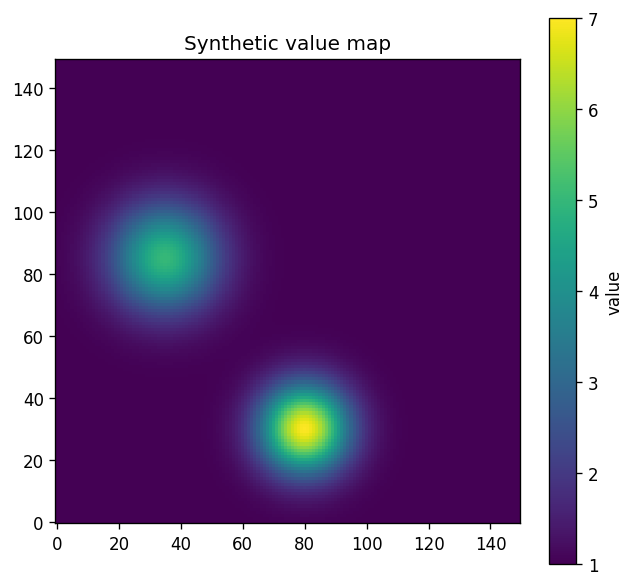

Value blocking (s, r, delta):
  s=0.746 r=0.60 delta=0.0 deg
  s=0.454 r=0.60 delta=0.0 deg
  s=0.794 r=0.60 delta=0.0 deg
  s=0.698 r=0.60 delta=0.0 deg
  s=0.406 r=0.60 delta=0.0 deg
  s=0.502 r=0.60 delta=0.0 deg
Applying retardant drop: D=[[80.25  29.124 -1.704]
 [36.682 84.585 -3.148]
 [93.498 29.538 -1.277]
 [66.532 31.339 -1.734]
 [39.652 97.59  -3.595]
 [37.927 71.066 -3.016]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2
Downwind blocking (s, r, delta):
  s=0.006 r=0.80 delta=12.4 deg
  s=0.054 r=0.80 delta=-13.2 deg
  s=0.956 r=0.80 delta=33.6 deg
  s=0.168 r=0.80 delta=-37.9 deg
  s=0.102 r=0.80 delta=-23.0 deg
  s=0.908 r=0.80 delta=33.8 deg
Applying retardant drop: D=[[127.827  81.406   0.245]
 [123.746  96.584   0.245]
 [124.751  65.14    0.245]
 [100.373 126.775   0.245]
 [114.661 109.997   0.245]
 [119.036  49.816   0.245]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


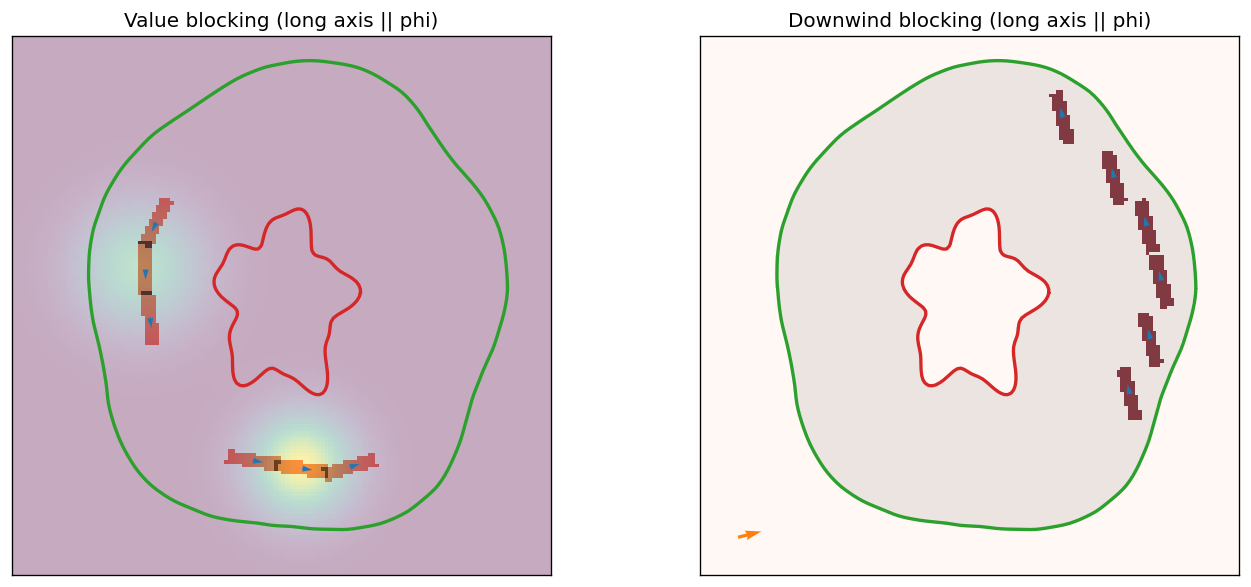

In [242]:
# Heuristic strategies across multiple scenarios with customizable (s, r, delta) outputs.

def build_value_map(nx, ny, peaks):
    X = np.arange(nx)[:, None]
    Y = np.arange(ny)[None, :]
    v = np.ones((nx, ny), dtype=float)
    for (cx, cy, amp, sigma) in peaks:
        v += float(amp) * np.exp(-((X - cx) ** 2 + (Y - cy) ** 2) / (2 * float(sigma) ** 2))
    return v


def arc_length_along_boundary(boundary_xy):
    seg = np.diff(np.vstack([boundary_xy, boundary_xy[0]]), axis=0)
    seg_len = np.hypot(seg[:, 0], seg[:, 1])
    return np.concatenate([[0.0], np.cumsum(seg_len[:-1])])


def greedy_select_indices(scores, arc_len, min_spacing, n_keep):
    order = np.argsort(scores)[::-1]
    selected = []
    total = float(arc_len[-1])
    for idx in order:
        if not np.isfinite(scores[idx]):
            continue
        ok = True
        for sidx in selected:
            d = abs(arc_len[idx] - arc_len[sidx])
            d = min(d, total - d)
            if d < min_spacing:
                ok = False
                break
        if ok:
            selected.append(int(idx))
        if len(selected) >= n_keep:
            break
    return selected


def restrict_by_compactness(scores, arc_len, compactness):
    compactness = float(np.clip(compactness, 0.0, 1.0))
    if compactness >= 1.0:
        return scores
    best = int(np.nanargmax(scores))
    span = compactness * float(arc_len[-1])
    total = float(arc_len[-1])
    out = np.full_like(scores, -np.inf, dtype=float)
    for i in range(len(scores)):
        d = abs(arc_len[i] - arc_len[best])
        d = min(d, total - d)
        if d <= span:
            out[i] = scores[i]
    return out


def indices_by_arclength(arc_len, n_keep):
    total = float(arc_len[-1])
    targets = np.linspace(0.0, total, int(n_keep), endpoint=False)
    idx = np.searchsorted(arc_len, targets)
    idx = np.clip(idx, 0, len(arc_len) - 1)
    return [int(i) for i in idx]


def s_r_delta_from_indices(indices, s_count, r_val, delta_val=0.0):
    s = [i / float(s_count) for i in indices]
    r = [float(r_val) for _ in indices]
    delta = [float(delta_val) for _ in indices]
    return list(zip(s, r, delta))


def value_blocking_strategy(grid, r_val, value_map, arc_len, *, n_keep, min_spacing, compactness):
    r_idx = int(round(float(r_val) * (grid.shape[1] - 1)))
    scores = []
    for i in range(grid.shape[0]):
        p = grid[i, r_idx]
        if not np.isfinite(p[0]):
            scores.append(-np.inf)
            continue
        ix = int(np.clip(round(p[0]), 0, nx - 1))
        iy = int(np.clip(round(p[1]), 0, ny - 1))
        scores.append(value_map[ix, iy])
    scores = np.array(scores, dtype=float)
    scores = restrict_by_compactness(scores, arc_len, compactness)
    sel = greedy_select_indices(scores, arc_len, min_spacing, n_keep)
    return s_r_delta_from_indices(sel, grid.shape[0], r_val, delta_val=0.0)


def downwind_blocking_strategy(grid, r_val, boundary_xy, wind_vec, arc_len, *, n_keep, min_spacing, compactness):
    wind_vec = np.asarray(wind_vec, dtype=float)
    wn = wind_vec / (np.linalg.norm(wind_vec) + 1e-9)
    scores = boundary_xy @ wn
    scores = restrict_by_compactness(scores, arc_len, compactness)
    sel = greedy_select_indices(scores, arc_len, min_spacing, n_keep)
    return s_r_delta_from_indices(sel, grid.shape[0], r_val, delta_val=0.0)


def surrounding_strategy(grid, r_val, arc_len, *, n_keep, grouping, group_span_frac=0.2):
    grouping = max(1, int(grouping))
    if grouping <= 1:
        sel = indices_by_arclength(arc_len, n_keep)
        return s_r_delta_from_indices(sel, grid.shape[0], r_val, delta_val=0.0)

    centers = indices_by_arclength(arc_len, grouping)
    counts = [n_keep // grouping] * grouping
    for i in range(n_keep % grouping):
        counts[i] += 1

    out = []
    total = float(arc_len[-1])
    span = float(group_span_frac) * total

    for center, ccount in zip(centers, counts):
        if ccount <= 0:
            continue
        targets = np.linspace(-span / 2.0, span / 2.0, ccount, endpoint=False)
        for t in targets:
            target_len = (arc_len[center] + t) % total
            idx = int(np.searchsorted(arc_len, target_len))
            idx = min(idx, len(arc_len) - 1)
            out.append(idx)

    return s_r_delta_from_indices(out, grid.shape[0], r_val, delta_val=0.0)


def apply_drops_from_sr(grid, sr_delta, phi_grid, drop_w_km, drop_h_km):
    points = []
    phi_long = []
    for s, r, delta in sr_delta:
        i = int(round(float(s) * (grid.shape[0] - 1)))
        j = int(round(float(r) * (grid.shape[1] - 1)))
        p = grid[i, j]
        if not np.isfinite(p[0]):
            continue
        points.append(p)
        phi_long.append(phi_grid[i, j] + float(delta))

    if not points:
        return None, np.array([]), np.array([])

    points = np.array(points, dtype=float)
    phi_long = np.array(phi_long, dtype=float)
    phi_width = phi_long - np.pi / 2.0

    state = FireState(
        burning=np.zeros((1, nx, ny), dtype=bool),
        burned=np.zeros((1, nx, ny), dtype=bool),
        burn_remaining_s=np.zeros((1, nx, ny), dtype=float),
        retardant=np.zeros((1, nx, ny), dtype=float),
        t=0,
    )

    model.apply_retardant_cartesian(
        state,
        np.column_stack([points[:, 0], points[:, 1], phi_width]),
        drop_w_km=drop_w_km,
        drop_h_km=drop_h_km,
        amount=1.0,
        avoid_burning=False,
        forbid_burning_overlap=False,
        burning_prob_threshold=0.25,
        cell_cap=None,
    )

    return state, points, phi_long


heuristic_scenarios = [
    {
        "name": "smooth_east_wind",
        "p_init": make_prob_map(nx, ny, (nx // 2, ny // 2), radius_cells=14, stretch=(1.0, 1.0), jitter_amp=0.0, sigma=2.5),
        "wind_vec": (6.0, 0.0),
        "value_peaks": [(80, 30, 6.0, 10.0), (35, 85, 4.0, 12.0)],
    },
    {
        "name": "jagged_north_wind",
        "p_init": make_prob_map(nx, ny, (nx // 2, ny // 2), radius_cells=14, stretch=(1.0, 1.35), jitter_amp=0.28, k1=5, k2=11, phase=0.6, sigma=2.0),
        "wind_vec": (0.0, 6.0),
        "value_peaks": [(70, 20, 5.5, 9.0), (30, 90, 3.5, 11.0), (95, 70, 2.5, 12.0)],
    },
    {
        "name": "lobed_sw_wind",
        "p_init": make_prob_map(nx, ny, (nx // 2, ny // 2), radius_cells=13, stretch=(0.9, 1.4), jitter_amp=0.35, k1=7, k2=13, phase=1.2, sigma=1.8),
        "wind_vec": (-4.0, -3.0),
        "value_peaks": [(25, 40, 6.0, 11.0), (90, 95, 4.5, 10.0)],
    },
]

# Drop dimensions and spacing.
drop_w_km = 0.005
drop_h_km = 0.05
cell_size_km = model.env.domain_km / nx
width_cells = drop_w_km / cell_size_km
min_spacing = 2.0 * width_cells

# Strategy parameters (customize here)
value_params = {"distance": 0.6, "compactness": 0.25, "n_keep": 6}
downwind_params = {"distance": 0.8, "compactness": 0.25, "n_keep": 6}
surround_params = {"distance": 0.35, "grouping": 2, "group_span_frac": 0.2, "n_keep": 8}

for sc in heuristic_scenarios:
    wind_vec = np.asarray(sc["wind_vec"], dtype=float)
    wind = np.zeros((nx, ny, 2), dtype=float)
    wind[..., 0] = wind_vec[0]
    wind[..., 1] = wind_vec[1]
    env_override = replace(env, wind=wind)
    model_override = CAFireModel(env_override, seed=4)

    res = run_elliptic_case(
        sc["name"],
        sc["p_init"],
        T=300.0,
        n_sims=200,
        K=500,
        n_r=160,
        sigma_boundary=2.0,
        smooth_iters=350,
        omega=1.0,
        model_override=model_override,
    )

    grid = res["grid"]
    mask = res["mask"]
    init_boundary = res["init_boundary"]
    final_boundary = res["final_boundary"]

    value_map = build_value_map(nx, ny, sc["value_peaks"])
    arc_len = arc_length_along_boundary(init_boundary.xy)
    phi_grid = grid_angle_along_s(grid)

    sr_value = value_blocking_strategy(
        grid,
        value_params["distance"],
        value_map,
        arc_len,
        n_keep=value_params["n_keep"],
        min_spacing=min_spacing,
        compactness=value_params["compactness"],
    )

    sr_downwind = downwind_blocking_strategy(
        grid,
        downwind_params["distance"],
        init_boundary.xy,
        wind_vec,
        arc_len,
        n_keep=downwind_params["n_keep"],
        min_spacing=min_spacing,
        compactness=downwind_params["compactness"],
    )

    sr_surround = surrounding_strategy(
        grid,
        surround_params["distance"],
        arc_len,
        n_keep=surround_params["n_keep"],
        grouping=surround_params["grouping"],
        group_span_frac=surround_params["group_span_frac"],
    )

    state_value, points_value, phi_long_value = apply_drops_from_sr(grid, sr_value, phi_grid, drop_w_km, drop_h_km)
    state_wind, points_wind, phi_long_wind = apply_drops_from_sr(grid, sr_downwind, phi_grid, drop_w_km, drop_h_km)
    state_surround, points_surround, phi_long_surround = apply_drops_from_sr(grid, sr_surround, phi_grid, drop_w_km, drop_h_km)

    print(f"
Scenario: {sc['name']}")
    print("  Value blocking (s,r,delta):", [(round(s, 3), round(r, 2), round(np.degrees(d), 1)) for s, r, d in sr_value])
    print("  Downwind blocking (s,r,delta):", [(round(s, 3), round(r, 2), round(np.degrees(d), 1)) for s, r, d in sr_downwind])
    print("  Surrounding (s,r,delta):", [(round(s, 3), round(r, 2), round(np.degrees(d), 1)) for s, r, d in sr_surround])

    fig, axes = plt.subplots(1, 3, figsize=(14, 5))

    axes[0].imshow(value_map.T, origin="lower", aspect="equal", cmap="viridis")
    if state_value is not None:
        axes[0].imshow(state_value.retardant[0].T, origin="lower", aspect="equal", cmap="Reds", alpha=0.7)
    axes[0].plot(init_boundary.xy[:, 0], init_boundary.xy[:, 1], color="tab:red", linewidth=2)
    axes[0].plot(final_boundary.xy[:, 0], final_boundary.xy[:, 1], color="tab:green", linewidth=2)
    if points_value.size:
        axes[0].quiver(
            points_value[:, 0],
            points_value[:, 1],
            np.cos(phi_long_value),
            np.sin(phi_long_value),
            angles="xy",
            scale_units="xy",
            scale=0.35,
            color="tab:blue",
            width=0.004,
        )
    axes[0].set_title("Value blocking (long axis parallel phi)")
    axes[0].set_xticks([])
    axes[0].set_yticks([])

    axes[1].imshow(mask.T, origin="lower", aspect="equal", cmap="Greys", alpha=0.25)
    if state_wind is not None:
        axes[1].imshow(state_wind.retardant[0].T, origin="lower", aspect="equal", cmap="Reds", alpha=0.7)
    axes[1].plot(init_boundary.xy[:, 0], init_boundary.xy[:, 1], color="tab:red", linewidth=2)
    axes[1].plot(final_boundary.xy[:, 0], final_boundary.xy[:, 1], color="tab:green", linewidth=2)
    if points_wind.size:
        axes[1].quiver(
            points_wind[:, 0],
            points_wind[:, 1],
            np.cos(phi_long_wind),
            np.sin(phi_long_wind),
            angles="xy",
            scale_units="xy",
            scale=0.35,
            color="tab:blue",
            width=0.004,
        )
    axes[1].quiver(
        [10],
        [10],
        [wind_vec[0]],
        [wind_vec[1]],
        angles="xy",
        scale_units="xy",
        scale=0.20,
        color="tab:orange",
        width=0.006,
    )
    axes[1].set_title("Downwind blocking (long axis parallel phi)")
    axes[1].set_xticks([])
    axes[1].set_yticks([])

    axes[2].imshow(mask.T, origin="lower", aspect="equal", cmap="Greys", alpha=0.25)
    if state_surround is not None:
        axes[2].imshow(state_surround.retardant[0].T, origin="lower", aspect="equal", cmap="Reds", alpha=0.7)
    axes[2].plot(init_boundary.xy[:, 0], init_boundary.xy[:, 1], color="tab:red", linewidth=2)
    axes[2].plot(final_boundary.xy[:, 0], final_boundary.xy[:, 1], color="tab:green", linewidth=2)
    if points_surround.size:
        axes[2].quiver(
            points_surround[:, 0],
            points_surround[:, 1],
            np.cos(phi_long_surround),
            np.sin(phi_long_surround),
            angles="xy",
            scale_units="xy",
            scale=0.35,
            color="tab:blue",
            width=0.004,
        )
    axes[2].set_title("Surrounding (long axis parallel phi)")
    axes[2].set_xticks([])
    axes[2].set_yticks([])

    plt.tight_layout()
    plt.show()

In [ ]:
# Additional (s, r, delta) heuristics + parameter sweeps (elliptic grid only).

scenario_idx = 1
res = results[scenario_idx]

grid = res["grid"]
mask = res["mask"]
init_boundary = res["init_boundary"]

phi_grid = grid_angle_along_s(grid)

# Build a value map for testing.
value_map = build_value_map(
    nx,
    ny,
    peaks=[(75, 28, 6.0, 10.0), (40, 90, 4.5, 12.0), (95, 70, 2.5, 14.0)],
)

# Mean wind direction from environment.
if env.wind.ndim == 4:
    wind_vec = env.wind.mean(axis=(0, 1, 2))
elif env.wind.ndim == 3:
    wind_vec = env.wind.mean(axis=(0, 1))
else:
    wind_vec = np.array([1.0, 0.0])

wind_vec = np.asarray(wind_vec, dtype=float)
wind_unit = wind_vec / (np.linalg.norm(wind_vec) + 1e-9)

# Arc length along inner boundary.
arc_len = arc_length_along_boundary(init_boundary.xy)

# Helpers for SR heuristics.

def compact_scores(scores, compactness):
    compactness = float(np.clip(compactness, 0.0, 1.0))
    if compactness >= 1.0:
        return scores
    best = int(np.nanargmax(scores))
    total = float(arc_len[-1])
    span = compactness * total
    out = np.full_like(scores, -np.inf, dtype=float)
    for i in range(len(scores)):
        d = abs(arc_len[i] - arc_len[best])
        d = min(d, total - d)
        if d <= span:
            out[i] = scores[i]
    return out


def select_indices(scores, n_keep, min_spacing):
    order = np.argsort(scores)[::-1]
    selected = []
    total = float(arc_len[-1])
    for idx in order:
        if not np.isfinite(scores[idx]):
            continue
        ok = True
        for sidx in selected:
            d = abs(arc_len[idx] - arc_len[sidx])
            d = min(d, total - d)
            if d < min_spacing:
                ok = False
                break
        if ok:
            selected.append(int(idx))
        if len(selected) >= n_keep:
            break
    return selected


def sr_from_indices(indices, r_val, delta_val=0.0):
    return [(i / float(grid.shape[0]), float(r_val), float(delta_val)) for i in indices]


def sr_value_ridge(r_val, *, n_keep, min_spacing, compactness, value_power=1.0):
    r_idx = int(round(float(r_val) * (grid.shape[1] - 1)))
    scores = []
    for i in range(grid.shape[0]):
        p = grid[i, r_idx]
        if not np.isfinite(p[0]):
            scores.append(-np.inf)
            continue
        ix = int(np.clip(round(p[0]), 0, nx - 1))
        iy = int(np.clip(round(p[1]), 0, ny - 1))
        scores.append(value_map[ix, iy])
    scores = np.power(np.asarray(scores, float), float(value_power))
    scores = compact_scores(scores, compactness)
    idx = select_indices(scores, n_keep, min_spacing)
    return sr_from_indices(idx, r_val, delta_val=0.0)


def sr_crosswind_barrier(r_val, *, n_keep, min_spacing, compactness, crosswind_power=1.0):
    # Use vector from inner to outer at each s to estimate spread direction.
    v_out = grid[:, -1] - grid[:, 0]
    v_unit = v_out / (np.linalg.norm(v_out, axis=1, keepdims=True) + 1e-9)
    align = np.clip(np.sum(v_unit * wind_unit[None, :], axis=1), -1.0, 1.0)
    cross = 1.0 - np.abs(align)
    scores = np.power(np.clip(cross, 0.0, None), float(crosswind_power))
    scores = compact_scores(scores, compactness)
    idx = select_indices(scores, n_keep, min_spacing)
    return sr_from_indices(idx, r_val, delta_val=0.0)


def sr_centroid_guard(r_val, *, n_keep, min_spacing, compactness, value_quantile=0.9):
    flat = value_map.ravel()
    thresh = np.quantile(flat, float(np.clip(value_quantile, 0.0, 1.0)))
    mask_hi = value_map >= thresh
    if not np.any(mask_hi):
        return []
    coords = np.column_stack(np.where(mask_hi)).astype(float)
    centroid = coords.mean(axis=0)
    vec = centroid[None, :] - init_boundary.xy
    v_unit = vec / (np.linalg.norm(vec, axis=1, keepdims=True) + 1e-9)
    v_out = grid[:, -1] - grid[:, 0]
    out_unit = v_out / (np.linalg.norm(v_out, axis=1, keepdims=True) + 1e-9)
    scores = np.sum(v_unit * out_unit, axis=1)
    scores = compact_scores(scores, compactness)
    idx = select_indices(scores, n_keep, min_spacing)
    return sr_from_indices(idx, r_val, delta_val=0.0)


def apply_drops_from_sr(grid, sr_delta, phi_grid, drop_w_km, drop_h_km):
    points = []
    phi_long = []
    for s, r, delta in sr_delta:
        i = int(round(float(s) * (grid.shape[0] - 1)))
        j = int(round(float(r) * (grid.shape[1] - 1)))
        p = grid[i, j]
        if not np.isfinite(p[0]):
            continue
        points.append(p)
        phi_long.append(phi_grid[i, j] + float(delta))

    if not points:
        return None, np.array([]), np.array([])

    points = np.array(points, dtype=float)
    phi_long = np.array(phi_long, dtype=float)
    phi_width = phi_long - np.pi / 2.0

    state = FireState(
        burning=np.zeros((1, nx, ny), dtype=bool),
        burned=np.zeros((1, nx, ny), dtype=bool),
        burn_remaining_s=np.zeros((1, nx, ny), dtype=float),
        retardant=np.zeros((1, nx, ny), dtype=float),
        t=0,
    )

    model.apply_retardant_cartesian(
        state,
        np.column_stack([points[:, 0], points[:, 1], phi_width]),
        drop_w_km=0.005,
        drop_h_km=0.05,
        amount=1.0,
        avoid_burning=False,
        forbid_burning_overlap=False,
        burning_prob_threshold=0.25,
        cell_cap=None,
    )

    return state, points, phi_long


def evaluate_sr(sr_delta):
    if not sr_delta:
        return {"n": 0, "avg_value": np.nan, "min_s_sep": np.nan}
    vals = []
    s_vals = []
    for s, r, _ in sr_delta:
        i = int(round(float(s) * (grid.shape[0] - 1)))
        j = int(round(float(r) * (grid.shape[1] - 1)))
        p = grid[i, j]
        ix = int(np.clip(round(p[0]), 0, nx - 1))
        iy = int(np.clip(round(p[1]), 0, ny - 1))
        vals.append(value_map[ix, iy])
        s_vals.append(s)
    s_vals = np.sort(np.asarray(s_vals, float))
    min_sep = np.min(np.diff(s_vals)) if len(s_vals) > 1 else np.nan
    return {"n": len(sr_delta), "avg_value": float(np.mean(vals)), "min_s_sep": float(min_sep)}

# Parameter sweeps.

min_spacing = 2.0 * (0.005 / (model.env.domain_km / nx))

sweep_results = []

for r_val in [0.45, 0.60, 0.75]:
    for compactness in [0.2, 0.5, 0.8]:
        for n_keep in [4, 6, 8]:
            sr = sr_value_ridge(
                r_val,
                n_keep=n_keep,
                min_spacing=min_spacing,
                compactness=compactness,
                value_power=1.2,
            )
            stats = evaluate_sr(sr)
            sweep_results.append(("value_ridge", r_val, compactness, n_keep, stats))

for r_val in [0.55, 0.70, 0.85]:
    for compactness in [0.2, 0.5, 0.8]:
        for n_keep in [4, 6, 8]:
            sr = sr_crosswind_barrier(
                r_val,
                n_keep=n_keep,
                min_spacing=min_spacing,
                compactness=compactness,
                crosswind_power=1.5,
            )
            stats = evaluate_sr(sr)
            sweep_results.append(("crosswind", r_val, compactness, n_keep, stats))

for r_val in [0.35, 0.50, 0.65]:
    for compactness in [0.2, 0.5, 0.8]:
        for n_keep in [4, 6, 8]:
            sr = sr_centroid_guard(
                r_val,
                n_keep=n_keep,
                min_spacing=min_spacing,
                compactness=compactness,
                value_quantile=0.9,
            )
            stats = evaluate_sr(sr)
            sweep_results.append(("centroid", r_val, compactness, n_keep, stats))

# Show top 8 by avg value.

sweep_sorted = sorted(sweep_results, key=lambda x: -x[4]["avg_value"])[:8]
print("Top SR heuristic configs (by avg value at drops):")
for name, r_val, comp, n_keep, stats in sweep_sorted:
    print(
        f"{name:10s} r={r_val:.2f} comp={comp:.2f} n={n_keep} "
        f"avg_value={stats['avg_value']:.3f} min_s_sep={stats['min_s_sep']:.3f}"
    )

# Visualize the top config from each heuristic family.

best_by_family = {}
for name, r_val, comp, n_keep, stats in sweep_sorted:
    if name not in best_by_family:
        best_by_family[name] = (r_val, comp, n_keep)

fig, axes = plt.subplots(1, 3, figsize=(14, 5))

for ax, (name, params) in zip(axes, best_by_family.items()):
    r_val, comp, n_keep = params
    if name == "value_ridge":
        sr = sr_value_ridge(r_val, n_keep=n_keep, min_spacing=min_spacing, compactness=comp, value_power=1.2)
    elif name == "crosswind":
        sr = sr_crosswind_barrier(r_val, n_keep=n_keep, min_spacing=min_spacing, compactness=comp, crosswind_power=1.5)
    else:
        sr = sr_centroid_guard(r_val, n_keep=n_keep, min_spacing=min_spacing, compactness=comp, value_quantile=0.9)

    state, points, phi_long = apply_drops_from_sr(grid, sr, phi_grid, 0.005, 0.05)

    ax.imshow(mask.T, origin="lower", aspect="equal", cmap="Greys", alpha=0.25)
    if state is not None:
        ax.imshow(state.retardant[0].T, origin="lower", aspect="equal", cmap="Reds", alpha=0.7)
    ax.plot(init_boundary.xy[:, 0], init_boundary.xy[:, 1], color="tab:red", linewidth=2)
    ax.plot(res["final_boundary"].xy[:, 0], res["final_boundary"].xy[:, 1], color="tab:green", linewidth=2)
    if points.size:
        ax.quiver(
            points[:, 0],
            points[:, 1],
            np.cos(phi_long),
            np.sin(phi_long),
            angles="xy",
            scale_units="xy",
            scale=0.35,
            color="tab:blue",
            width=0.004,
        )
    ax.set_title(f"{name} (r={r_val:.2f}, comp={comp:.2f}, n={n_keep})")
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

# Plot selected SR configs (value, downwind, surrounding + others).

def sr_value_blocking(r_val, n_keep, compactness):
    return sr_value_ridge(r_val, n_keep=n_keep, min_spacing=min_spacing, compactness=compactness, value_power=1.0)


def sr_downwind_blocking(r_val, n_keep, compactness):
    # choose s by dot(boundary tangent, wind) head alignment
    tang = init_boundary.xy
    scores = tang @ wind_unit
    scores = compact_scores(scores, compactness)
    idx = select_indices(scores, n_keep, min_spacing)
    return sr_from_indices(idx, r_val, delta_val=0.0)


def sr_surrounding(r_val, n_keep, grouping, group_span_frac):
    # group around the boundary
    return surrounding_strategy(grid, r_val, arc_len, n_keep=n_keep, grouping=grouping, group_span_frac=group_span_frac)

selected_configs = [
    ("value_blocking", sr_value_blocking(0.60, n_keep=6, compactness=0.35)),
    ("downwind_blocking", sr_downwind_blocking(0.80, n_keep=6, compactness=0.35)),
    ("surrounding", sr_surrounding(0.35, n_keep=8, grouping=2, group_span_frac=0.2)),
    ("value_ridge", sr_value_ridge(0.60, n_keep=6, min_spacing=min_spacing, compactness=0.5, value_power=1.2)),
    ("crosswind", sr_crosswind_barrier(0.70, n_keep=6, min_spacing=min_spacing, compactness=0.5, crosswind_power=1.5)),
    ("centroid_guard", sr_centroid_guard(0.50, n_keep=6, min_spacing=min_spacing, compactness=0.5, value_quantile=0.9)),
]

fig, axes = plt.subplots(2, 3, figsize=(14, 9))
axes = axes.ravel()

for ax, (name, sr_cfg) in zip(axes, selected_configs):
    state, points, phi_long = apply_drops_from_sr(grid, sr_cfg, phi_grid, 0.005, 0.05)
    ax.imshow(mask.T, origin="lower", aspect="equal", cmap="Greys", alpha=0.25)
    if state is not None:
        ax.imshow(state.retardant[0].T, origin="lower", aspect="equal", cmap="Reds", alpha=0.7)
    ax.plot(init_boundary.xy[:, 0], init_boundary.xy[:, 1], color="tab:red", linewidth=2)
    ax.plot(res["final_boundary"].xy[:, 0], res["final_boundary"].xy[:, 1], color="tab:green", linewidth=2)
    if points.size:
        ax.quiver(
            points[:, 0],
            points[:, 1],
            np.cos(phi_long),
            np.sin(phi_long),
            angles="xy",
            scale_units="xy",
            scale=0.35,
            color="tab:blue",
            width=0.004,
        )
    ax.set_title(name)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()
